# PDF da campioni discreti

Esistono diversi modi per approssimare una PDF ottenuta da un campione discreto. Vedremo nel seguito due modi tra i più usati.

## Generiamo un campione discreto

Innanzitutto, procuriamoci un campione discreto. In assenza di dati sperimentali, possiamo generarlo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.stats import norm
import math

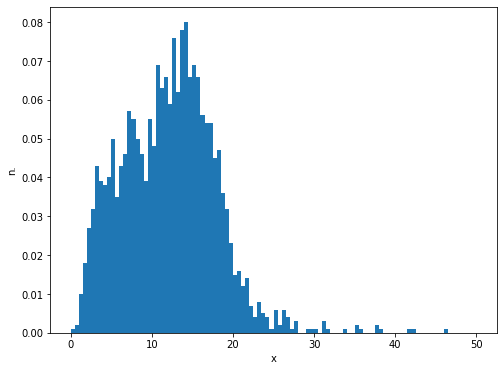

In [2]:
pdf1 = gamma(2.5, scale=4)
pdf2 = norm(loc=15,scale=3)
w1, w2 = 0.6, 0.4
nrnd = 2000
seq1 = pdf1.rvs(size=int(w1*nrnd))
seq2 = pdf2.rvs(size=int(w2*nrnd))
seq=np.concatenate((seq1,seq2), axis=0)
plt.figure(figsize=(8,6))
nbins=100
xrange = (0,50)
step=(xrange[1]-xrange[0])/nbins
n, bins, patches = plt.hist(seq, nbins, density=True, range=xrange)
plt.xlabel("x")
plt.ylabel("n.")
plt.show()

## Smoothing

Esistono diverse tecniche per generare polinomiali oppure polinomiali a tratti. Non andremo nei dettagli, ma si trovano diversi algoritmi in rete. Tra questi:
* [```savgol_filter```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html)

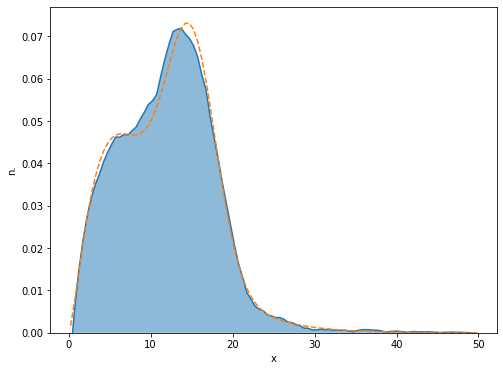

In [3]:
from scipy.signal import savgol_filter
n_smooth = savgol_filter(n, 15, 3) # window size 7, polynomial order 3
x_bins=bins[:-1]+step/2
plt.figure(figsize=(8,6))
plt.fill_between(x_bins, n_smooth, alpha=0.5)
plt.plot(x_bins, n_smooth)
plt.plot(x_bins, w1*pdf1.pdf(x_bins)+w2*pdf2.pdf(x_bins), linestyle='--')
plt.ylim(0)
plt.xlabel("x")
plt.ylabel("n.")
plt.show()

Dopo lo smoothing andrebbe fatta un'interpolazione per avere una distribuzione continua anziché discreta.

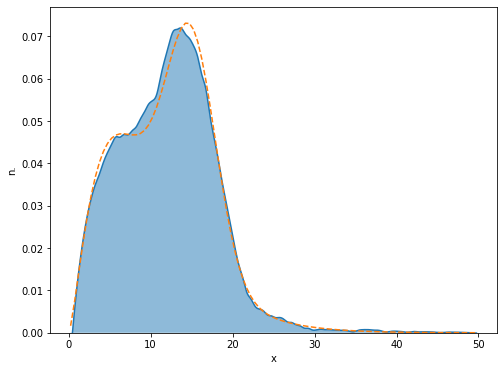

In [4]:
from scipy.interpolate import interp1d
n_interp = interp1d(x_bins, n_smooth, kind='cubic')
xs = np.linspace(x_bins[0], x_bins[-1], 400)
ys = n_interp(xs)
plt.figure(figsize=(8,6))
plt.fill_between(xs, ys, alpha=0.5)
plt.plot(xs, ys)
plt.plot(x_bins, w1*pdf1.pdf(x_bins)+w2*pdf2.pdf(x_bins), linestyle='--')
plt.ylim(0)
plt.xlabel("x")
plt.ylabel("n.")
plt.show()

# Kernel density estimation

La PDF finale è la somma di $N$ gaussiane centrate intorno ad ogni singolo valore discreto. In alternativa si possono usare altre distribuzioni.

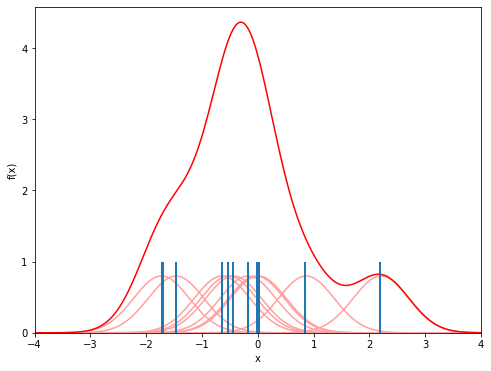

In [42]:
xseq=np.random.normal(size=10)
xmin, xmax = -4, 4
sigma = 0.5
xs = np.linspace(xmin, xmax, num=500)
kernel = np.array([norm.pdf(xs - xseq[i], scale=sigma) for i in range(len(xseq))])
pdf = np.sum(kernel, axis=0)
plt.figure(figsize=(8,6))
plt.hist(xseq,bins=100,zorder=10)
for i in range(len(kernel)):
    plt.plot(xs, kernel[i], color='#ffa0a0')
plt.plot(xs, pdf, color='red')
plt.xlim(xmin,xmax)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

Questo metodo è particolarmente utile quando la dimensione del campione è particolarmente piccola, tanto che lo smoothing non è applicabile in maniera soddisfacente.

* [In-Depth: Kernel Density Estimation
](https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html)
* [```gaussian_kde```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html)

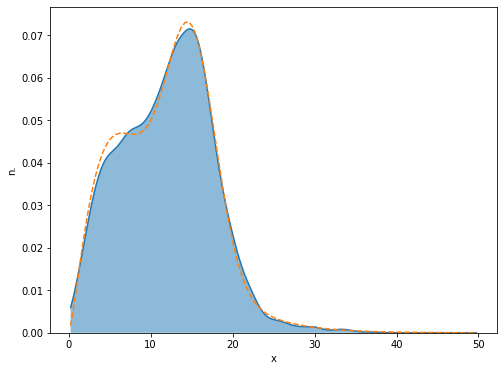

In [5]:
density = sum(norm(xi).pdf(xs) for xi in seq)
# normalize
density/=(density.sum()*(xrange[1]-xrange[0])/len(xs))
plt.figure(figsize=(8,6))
plt.fill_between(xs, density, alpha=0.5)
plt.plot(xs, density)
plt.plot(x_bins, w1*pdf1.pdf(x_bins)+w2*pdf2.pdf(x_bins), linestyle='--')
plt.ylim(0)
plt.xlabel("x")
plt.ylabel("n.")
plt.show()

Usando una classe ad hoc, [```KernelDensity```](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html). Nella documentazione ci sono anche esempi bidimensionali.

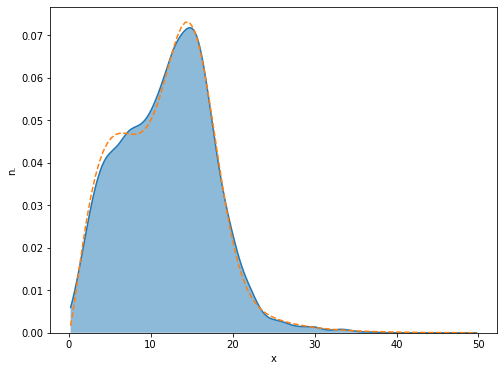

In [7]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(seq[:, None])
kde_density = np.exp(kde.score_samples(xs[:, None]))
plt.figure(figsize=(8,6))
plt.fill_between(xs, kde_density, alpha=0.5)
plt.plot(xs, kde_density)
plt.plot(x_bins, w1*pdf1.pdf(x_bins)+w2*pdf2.pdf(x_bins), linestyle='--')
plt.ylim(0)
plt.xlabel("x")
plt.ylabel("n.")
plt.show()

## Quando usare un metodo o l'altro?

Lo smoothing funziona male quando il numero di osservazioni è basso e l'istogramma di fatto si riduce ad un insieme di valori sparsi. In quel caso, una KDE funziona meglio se si sceglie la larghezza del kernel in modo da coprire l'area "vuota" intorno ai casi discreti e "riempire" le aree vuote.

Viceversa, la KDE potrebbe essere molto lenta se applicata ad un numero molto alto di casi, perché richiede il calcolo della distribuzione del kernel per ogni osservazione.